# Text Classification

Text classification is the process of assigning tags or categories to text according to its content. It’s one of the fundamental tasks in natural language processing. 

The text we wanna classify is given as input to an algorithm, the algorithm will then analyze the text’s content, and then categorize the input as one of the tags or categories previously given.

**Input → Classifying Algorithm → Classification of Input**

Real life examples: 

+ sentiment analysis: how does the writer of the sentence feel about what they are writing about, do they think positively or negatively of the subject?Ex. restaurant reviews
+ topic labeling: given sentences and a set of topics, which topic does this sentence fall under?  Ex. is this essay about history? Math? etc?
+ spam detection. Ex. Email filtering: is this email a real important email or spam?

Example. 
A restaurant wants to evaluate their ratings but don’t want to read through all of them. Therefore, they wanna use a computer algorithm to do all their work. They simply want to know if the customer’s review is positive or negative.

Here’s an example of a customer’s review and a simple way an algorithm could classify their review.

Input: “The food here was too salty and too expensive” 

Algorithm: 
Goes through every word in the sentence and counts how many positive words and how many negative words are in the sentence.

		“The, food, here, was, too, and” are all neutral words

		“Salty, expensive” are negative words.

		Negative words: 2
		Positive words: 0

Classification: Negative Review, because there are more negative words (2) than positive (0).

However, this algorithm obviously doesn’t work in a lot of cases. 

For example, “The food here was good, not expensive and not salty” would be classified as negative but it’s actually a positive review. 

Language and text can get very complicated which makes creating these algorithms difficult. Some things that make language difficult could be words that have multiple meanings, negation words (words such as not), slang, etc.



## Importing Data

In [1]:
# !pip3 install nltk
# !pip3 install ipywidgets
# !pip3 install tensorflow
# !pip3 install keras

import sys
import string
from scipy import sparse
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from IPython.display import display
import ipywidgets as widgets

# Our two files that contain our data, split up into a training set and a testing set.

trainingFile = "dataset/trainingSet.txt"
testingFile = "dataset/testSet.txt"

In [2]:
def getData(fileName):
    f = open(fileName)
    file = f.readlines()

    sentences = []
    sentiments = []

    for line in file:
        sentence, sentiment = line.split('\t')
        sentences.append(sentence.strip())
        sentiments.append(int(sentiment.strip())) # Sentiment in {0,1}

    return sentences, np.array(sentiments)

In [3]:
trainingSentences, trainingLabels = getData(trainingFile)
testingSentences, testingLabels = getData(testingFile)

## Pre-Processing Data

In [4]:
def cleanText(sentence):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

def preProcess(text):
    # Make lower case
    text = text.lower()

    # Replace non-text characters with spaces
    nonText = string.punctuation + ("")
    text = text.translate(str.maketrans(nonText, ' ' * (len(nonText))))

    # Tokenize
    words = text.split()

    return words

<AxesSubplot:xlabel='sentiment', ylabel='count'>

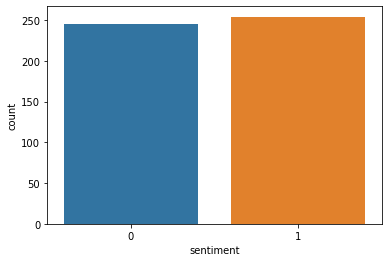

In [5]:
train_sentence = []
train_words = []
test_sentence = []
test_words = []
# get cleaned sentences and bag of words
for sen in trainingSentences:
    train_sentence.append(cleanText(sen))
    train_words.append(preProcess(sen))
for sen in testingSentences:
    test_sentence.append(cleanText(sen))
    test_words.append(preProcess(sen))
# print(train_sentence[0])


# print(train_words)

import seaborn as sns
import pandas as pd
train_df = pd.DataFrame(data=trainingLabels, columns=["sentiment"])
sns.countplot(x='sentiment', data=train_df)

## Getting Data and Setting it Up

In [6]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from keras.callbacks import Callback

from numpy import array
from numpy import asarray
from numpy import zeros

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import json
import os

def getVocab(sentences):
    vocab = set()
    for sentence in sentences:
        for word in sentence:
            vocab.add(word)
    return sorted(vocab)

In [7]:
vocabulary = getVocab(train_words)

In [8]:
def clicked(arg):
    print(vocabulary)

button_download = widgets.Button(description = 'Click to see Vocab')   
button_download.on_click(clicked)
display(button_download)

Button(description='Click to see Vocab', style=ButtonStyle())

In [9]:
def createVector(vocab, sentences):
    indices = []
    wordOccurrences = []

    for sentenceIndex, sentence in enumerate(sentences):
        alreadyCounted = set() # Keep track of words so we don't double count.
        for word in sentence:
            if (word in vocab) and word not in alreadyCounted:
                # If we just want {0,1} for the presence of the word (bernoulli NB),
                # only count each word once. Otherwise (multinomial NB) count each
                # occurrence of the word.
                
            
                #which sentence, which word
                indices.append((sentenceIndex, vocab.index(word)))
                
                wordOccurrences.append(1)
                alreadyCounted.add(word)

    # Unzip
    rows = [row for row, _ in indices]
    columns = [column for _, column in indices]

    sentenceVectors = sparse.csr_matrix((wordOccurrences, (rows, columns)), dtype=int, shape=(len(sentences), len(vocab)))

    return sentenceVectors

In [10]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train_sentence)

X_train = tokenizer.texts_to_sequences(train_sentence)
X_test = tokenizer.texts_to_sequences(test_sentence)
# print(X_train)

In [11]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 10

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
y_train = trainingLabels
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
y_test = testingLabels

In [12]:
# scaling confidence scores to range between 0 and 1 with MinMaxScaler
scaler = MinMaxScaler(feature_range=[0, 1])

In [13]:
# Function is called on each epoch finish
class ConfMatrixCallbackPlotter(Callback):
    def __init__(self, model, scaler, validation_data, original_input):
        super().__init__()
        self.model = model
        self.scaler = scaler
        self.validation_data = validation_data # Tuple
        self.original_input = original_input # input sentences
        self.collected_epoch_output = []
        
    def fitting_intermediate_results(self):
        return self.collected_epoch_output
    
    # Epoch is int representing finished epoch number
    # logs is a dict containing stats about finished epoch
    def on_epoch_end(self, epoch, logs={}):
        # Current function is to create this format:
        # Epoch, Index, True Label, Predicted Label, Confidence Score, Text
        # This requires the following inputs variables:
            # testingPredictions (derived from validation_data + model)
            # testingConfidenceScores (derived from validation_data + model)
            # testingLabels (y_test of validation_data should be identical)
            # testingSentences (we require this)
            
        test_predictions = (self.model.predict(self.validation_data[0]) > 0.5).astype("int32")
        test_conf_scores = self.model.predict(self.validation_data[0], batch_size=128)
        test_labels = self.validation_data[1]
        testing_sentences = self.original_input
        
#         self.scaler.fit(test_conf_scores)
#         test_conf_scores = self.scaler.transform(test_conf_scores)
        
        data = list(zip(np.full(len(testing_sentences), epoch), test_predictions, test_conf_scores,
                        test_labels, testing_sentences))
        
        # Replicating same JSON creation code below.
        self.collected_epoch_output.append(pd.DataFrame(data, 
                                                   columns=['Epoch', 'Test Prediction', 'Test Confidence Score',
                                                            'Test Label', 'Test Sentence']))

In [14]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# Setup Callback function
# Requires: model and validation_data (X and Y values of test data)
confusion_matrix_updates = ConfMatrixCallbackPlotter(
                                model = model,
                                scaler = scaler,
                                validation_data = (X_test, y_test),
                                original_input = testingSentences)

print(model.summary())

# Callback function must be used as input for model fitting.
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=2 , validation_data=(X_test, y_test), callbacks=[confusion_matrix_updates])
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

epoch_history_extracted_data = confusion_matrix_updates.fitting_intermediate_results()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           133200    
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1001      
Total params: 134,201
Trainable params: 1,001
Non-trainable params: 133,200
_________________________________________________________________
None
Epoch 1/20
4/4 - 0s - loss: 0.6937 - acc: 0.5070 - val_loss: 0.6930 - val_acc: 0.4909
Epoch 2/20
4/4 - 0s - loss: 0.6922 - acc: 0.5251 - val_loss: 0.6928 - val_acc: 0.5091
Epoch 3/20
4/4 - 0s - loss: 0.6911 - acc: 0.5431 - val_loss: 0.6926 - val_acc: 0.5111
Epoch 4/20
4/4 - 0s - loss: 0.6899 - acc: 0.5671 - val_loss: 0.6924 - val_acc: 0.5030
Epoch 5/20
4/4 - 0s - loss:

In [15]:
# make a prediction
testingPredictions = (model.predict(X_test) > 0.5).astype("int32")
# print(len(testingPredictions))
test_confidence_scores = model.predict(X_test, batch_size=128)
# print(test_confidence_scores)
target_names = ['negative', 'positive']
# print(classification_report(testingLabels, testingPredictions, target_names=target_names))

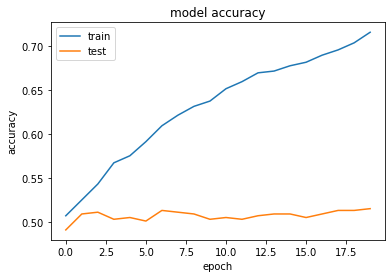

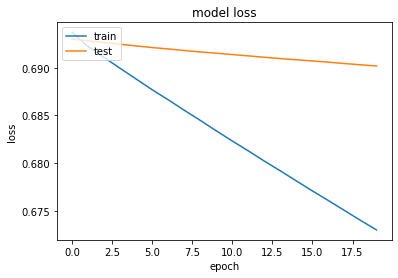

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

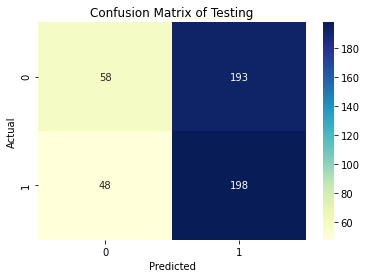

In [17]:
data = {'Actual':    testingLabels,
        'Predicted': testingPredictions.reshape(len(testingLabels),)
        }
#print(testingLabels.reshape(len(testingLabels),1))
df = pd.DataFrame(data, columns=['Actual','Predicted'])
confusion_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True,cmap="YlGnBu", fmt='d').set_title('Confusion Matrix of Testing')
plt.show()

In [18]:
output_directory = "libraries/"
output_filename = "predict_simple.json"
full_path = os.path.join(output_directory, output_filename)

data = []
for i in range(len(testingPredictions)):
  data.append({
      'index': i,
      'true_label': int(testingLabels[i]),
      'predicted_label': int(testingPredictions[i]),
      'confidence_score': test_confidence_scores.tolist()[i],
      'text': testingSentences[i]
  })

with open(full_path, 'w') as outfile:
    json.dump(data, outfile, indent=4, sort_keys=False)
    

collected_epoch_filename = 'predict_simple_extended.json'
full_path_extended = os.path.join(output_directory, collected_epoch_filename)

extended_data = {}
for i, table in enumerate(epoch_history_extracted_data):
    jsonified = table.to_json(orient='index')
    parsed = json.loads(jsonified)
#     extended_data.append(parsed)
    extended_data[f'{i}'] = parsed
    
# print(extended_data)
    
with open(full_path_extended, 'w') as outfile:
    json.dump(extended_data, outfile, indent=4, sort_keys=False)

In [19]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
import libraries.mlvislib as mlvs

In [20]:
cm = mlvs.ConfusionMatrix(full_path_extended)
cm.display()